In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from textwrap import wrap

## Example color scales

In [2]:
scale_agree = [
    "Strongly disagree",
    "Disagree",
    "Neither agree or disagree",
    "Agree",
    "Strongly agree",
]

In [3]:
scale_agree_color = sns.color_palette("RdBu", 5)

In [4]:
scale_high_color = sns.color_palette("PRGn", 5)

In [5]:
scale_likely = [
    "Very unlikely",
    "Unlikely",
    "About as likely as not",
    "Likely",
    "Very likely"
]

In [6]:
scale_likely_color = sns.color_palette("BrBG", 5)

In [7]:
scale_relevant = [
    "Not relevant",
    "Slightly relevant",
    "Moderately relevant",
    "Relevant",
    "Very relevant"
]

In [8]:
scale_relevant_color = sns.color_palette("BrBG", 5)

## Visualisation scripts

In [9]:
def barh_frequency(question, df, meta, xlabel='Number of respondents', file_name='', 
                   bar_height=0.6, ytick_width=40, width=6, color='#1283b1'):
    """Plot a horizontal barchart of the frequency of answers in a survey question."""
    
    data = df[question].value_counts().sort_values()
    size = data.sum()

    var_num = len(data.index)
    plt.figure(figsize=(width, bar_height*var_num))
    
    g = data.plot.barh(width=0.9, color=color)
    
    g.set_yticklabels(['\n'.join(wrap(l.get_text(), ytick_width)) for l in g.get_yticklabels()])
    g.set_title('\n'.join(wrap(meta[question].iloc[0]+" (n = {})".format(size),80)))
    g.set_ylabel("")
    g.set_xlabel(xlabel)

    if file_name:
        plt.savefig(f'figures/{file_name}', bbox_inches='tight')
    
    return g

In [10]:
def barh_percentage(question, df, meta, xlabel='Share of respondents in %', file_name='', 
                    bar_height=0.6, ytick_width=40, width=6, color='#1283b1'):
    """Plot a horizontal barchart of the percentage of answers in a survey question."""

    data = df[question].value_counts().sort_values()
    size = data.sum()
    data_percent = 100*data/size
    
    var_num = len(data_percent.index)
    plt.figure(figsize=(width, bar_height*var_num))

    g = data_percent.plot.barh(width=0.9, color=color)
    
    g.set_yticklabels(['\n'.join(wrap(l.get_text(), ytick_width)) for l in g.get_yticklabels()])
    g.set_title('\n'.join(wrap(meta[question].iloc[0]+" (n = {})".format(size),80)))
    g.set_ylabel("")
    g.set_xlabel(xlabel)

    if file_name:
        plt.savefig(f'figures/{file_name}', bbox_inches='tight')
    
    return g

In [11]:
def barh_split(question, separator, df, meta, percentage=False, xlabel='', file_name='', 
               bar_height=0.6, ytick_width=40, width=6, color='#1283b1'):
    """Plot a horizontal barchart of the frequency or percentage of answers in a survey question.
    after splitting the answers using a separator """
        
    split_question = df[question].str.split(separator,expand=True)
    split_cols = []
    for i in split_question.columns.tolist():
        split_cols.append(split_question[i])
    data = pd.concat(split_cols).value_counts().sort_values()
    size = len(df[question])

    var_num = len(data.index)
    plt.figure(figsize=(width, bar_height*var_num))
    
    if percentage:
        data_percent = 100*data/size
        g = data_percent.plot.barh(width=0.9, color=color)
        default_xlabel = 'Share of respondents in %'
    else:
        g = data.plot.barh(width=0.9, color=color)
        default_xlabel = 'Number of respondents'

    if xlabel:
        g.set_xlabel(xlabel)
    else:
        g.set_xlabel(default_xlabel)
    
    g.set_yticklabels([ '\n'.join(wrap(l.get_text(), ytick_width)) for l in g.get_yticklabels()])
    g.set_title('\n'.join(wrap(meta[question].iloc[0]+" (n = {})".format(size),80)))
    g.set_ylabel("")

    if file_name:
        plt.savefig(f'figures/{file_name}', bbox_inches='tight')
        
    return g

In [12]:
def lik2per(series, scale):
    """Convert a likert scale answer into a count."""
    
    value_counts = []
    for item in scale:
        value_counts.append(100*series[series==item].count()/series.count())
    return pd.DataFrame(value_counts,index=scale,columns=[series.name]).T

In [13]:
def barh_likert(var_to_plot, df, meta, scale_color, xlabel='Share of respondents in %', file_name='', 
                bar_height=1.2, width=8):
    """Plot a Likert scale-like diagram."""

    fig,ax = plt.subplots(len(var_to_plot),1,sharex=True,figsize=[width, bar_height*len(var_to_plot)])

    for i,var in enumerate(var_to_plot):
        lik2per(df[var],scale_agree).plot(kind="barh",ax=ax[i],width=1,legend=False,stacked=True,color=scale_color)
        ax[i].set_title('\n'.join(wrap(meta[var].loc["name"], 80)),pad=-6)

        ax[i].set_yticks([])
        ax[i].set_xlim(0,100)
        ax[i].patch.set_visible(False)

    axbox = ax[0].get_position()    
    ax[0].legend([mpatches.Patch(facecolor=tech_color,edgecolor="k") for tech_color in scale_color],
                     scale_agree,loc = (axbox.x0+0.9, axbox.y0+0.5),frameon=False
             )
    ax[-1].set_xlabel(xlabel)

    if file_name:
        plt.savefig(f'figures/{file_name}', bbox_inches='tight')
    
    return fig

In [14]:
def split_barh_likert(var_to_plot, df, meta, scale=scale_agree, scale_color=scale_agree_color, 
                      existing_title=False, xlabel='Share of respondents in %', file_name='', bar_height=1.1,
                      width=8):
    """Plot a Likert scale-like diagram where positive answers are split from negative."""

    fig,ax = plt.subplots(len(var_to_plot),1,sharex=True,figsize=[width,bar_height*len(var_to_plot)])
    
    for i,var in enumerate(var_to_plot):
        s_lik = lik2per(df[var],scale)
        
        s_pos = s_lik[[scale[2]]].divide(2).join(s_lik[[scale[3],scale[4]]])
        s_neg = -s_lik[[scale[2]]].divide(2).join(s_lik[[scale[1],scale[0]]])

        s_pos.plot(
            kind="barh",ax=ax[i],width=0.8,legend=False,stacked=True,color=scale_color[2:]
        )
        s_neg.plot(
            kind="barh",ax=ax[i],width=0.8,legend=False,stacked=True,color=list(scale_color)[:3][::-1]
        )
        title = '\n'.join(wrap(meta[var].iloc[0]+" (n={})".format(df[var].dropna().shape[0]), 80))
        if i==0 and existing_title:
            ax[i].set_title(title.replace("^","\'"),fontweight="bold")
        else:
            ax[i].set_title(title.replace("^","\'"))

        ax[i].set_yticks([])
        ax[i].set_xlim(-100,100)
        ax[i].set_xticks([-100,-75,-50,-25,0,25,50,75,100])
        ax[i].set_xticklabels(["100","75","50","25","0","25","50","75","100"])
        ax[i].set_xlabel(xlabel)
        ax[i].axvline(x=0,color="k",linewidth=0.5)
        
        share_agree = int(round(s_lik[[scale[3],scale[4]]].sum(axis=1).values[0],0))
        share_uncertain = int(round(s_lik[[scale[2]]].sum(axis=1).values[0],0))
        share_disagree = 100-share_agree-share_uncertain

        ax[i].text(0,-0.05,"{}%".format(share_uncertain),va="center",ha="center")
        ax[i].text(share_agree+share_uncertain/2+1,-0.05,"{}%".format(share_agree),va="center",ha="left")
        ax[i].text(-share_disagree-share_uncertain/2-1,-0.05,"{}%".format(share_disagree),va="center",ha="right")

    axbox = ax[0].get_position()    
    ax[0].legend([mpatches.Patch(facecolor=tech_color,edgecolor="k") for tech_color in scale_color],
                     scale,loc = (axbox.x0+0.9, axbox.y0-1.6),frameon=False
             )
    ax[-1].set_xlabel(xlabel)
    plt.subplots_adjust(hspace=1.5)
    
    if file_name:
        plt.savefig(f'figures/{file_name}', bbox_inches='tight')
    
    return fig

In [15]:
def barh_num_likert(df, meta, cat={}, scale=scale_agree, errorbar=None, xlabel='', file_name='', 
               bar_height=1.2, ytick_width=30, width=6):

    df_num = df.replace({s:i for i,s in enumerate(scale)}).melt()    
    df_agg = df_num.groupby(['variable'])['value'].mean().reset_index().sort_values('value',ascending=False)

    var_num = len(df_num.variable.unique())
    plt.figure(figsize=(width, bar_height*var_num))
    
    if cat:
        df_num['category'] = df_num[['variable']].replace(cat)
        g = sns.barplot(data=df_num,x='value',y='variable',order=df_agg['variable'],orient='h',errorbar=errorbar,width=0.8,
                       hue='category',dodge=False)
        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), frameon=False)
    else:
        g = sns.barplot(data=df_num,x='value',y='variable',order=df_agg['variable'],orient='h',errorbar=errorbar,width=0.8,
                       color=sns.color_palette()[0])
    
    g.set_yticklabels(['\n'.join(wrap(meta[l.get_text()][0], ytick_width)) for l in g.get_yticklabels()])
    g.set_xticks(range(len(scale_agree)))
    g.set_xticklabels('\n'.join(wrap(l , 10)) for l in scale_relevant)
    g.set_ylabel("")
    g.set_xlabel(xlabel)

    if file_name:
        plt.savefig(f'figures/{file_name}', bbox_inches='tight')
        
    return g

## Testing data

In [16]:
test_var = ['requirements_rel','open_rel','dependencies_rel']
test_data = {
    'requirements_rel': {0: 'Moderately relevant',
          1: 'Slightly relevant',
          2: 'Relevant'},
     'open_rel': {0: 'Relevant', 1: 'Moderately relevant', 2: 'Relevant'},
     'dependencies_rel': {0: 'Very relevant',
          1: 'Slightly relevant',
          2: 'Moderately relevant'}
}
test_meta = {
    'requirements_rel': {0: 'In your view, how relevant are requirements engineering practices to the development and uptake of your model?'},
    'open_rel': {0: 'How relevant are\xa0open-source practices to the development and uptake of your model?'},
    'dependencies_rel': {0: 'How relevant are\xa0practices for dependency management\xa0to the development and uptake of your model?'}
}
test_meta_short = {
    'requirements_rel': {0: 'Requirements engineering'},
    'open_rel': {0: 'Open-source practices'},
    'dependencies_rel': {0: 'Dependency management'}
}
test_meta_cat = {
    'requirements_rel': 'Model development',
    'open_rel': 'Versioning and collaboration',
    'dependencies_rel': 'Deployment'
}

In [17]:
df_test = pd.DataFrame(test_data)
meta_test = pd.DataFrame(test_meta)
meta_test_short = pd.DataFrame(test_meta_short)

<Axes: >

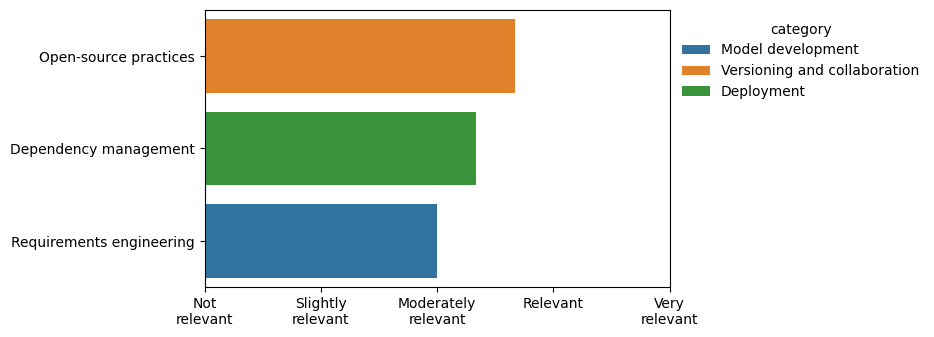

In [18]:
barh_num_likert(df_test, meta_test_short, cat=test_meta_cat, scale=scale_relevant, ytick_width=30)

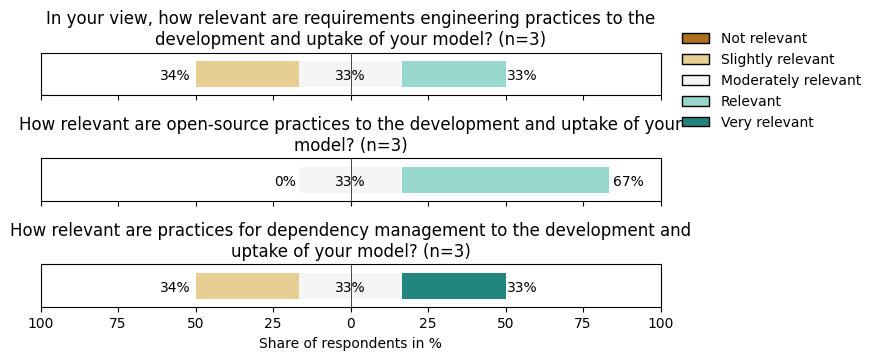

In [19]:
fig = split_barh_likert(test_var, df_test, meta_test, scale_relevant, scale_relevant_color)

## Export scripts

Export scripts so that they can be imported

In [20]:
!jupyter nbconvert --to script visualisation_scripts.ipynb

[NbConvertApp] Converting notebook visualisation_scripts.ipynb to script
[NbConvertApp] Writing 10813 bytes to visualisation_scripts.py
